<a href="https://colab.research.google.com/github/AmbroseNTK/ClassroomEvaluation/blob/master/notebooks/Facial_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facial Expression
In other to recognize student emotion. I need extract faces from images, then, classify them into some type of emotion (Happy, Fear, Disgust, Surprise, Angry, Neutral) 

Mount GDrive to save model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Using OpenCV to detection faces in a photo

In [0]:
import cv2
import json
from google.colab.patches import cv2_imshow

Using Haar Cascade

In [0]:
!git clone https://github.com/opencv/opencv.git

Cloning into 'opencv'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 257805 (delta 0), reused 0 (delta 0), pack-reused 257803
Receiving objects: 100% (257805/257805), 462.02 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (179562/179562), done.
Checking out files: 100% (5947/5947), done.


Download test image

In [0]:
!wget https://www.researchgate.net/profile/Oyebade_Oyedotun/publication/321776646/figure/fig1/AS:571121751212032@1513177444328/BU-3DFE-dataset-facial-expressions-32.png -O test.jpg

--2019-07-23 11:59:10--  https://www.researchgate.net/profile/Oyebade_Oyedotun/publication/321776646/figure/fig1/AS:571121751212032@1513177444328/BU-3DFE-dataset-facial-expressions-32.png
Resolving www.researchgate.net (www.researchgate.net)... 104.17.32.105, 104.17.33.105
Connecting to www.researchgate.net (www.researchgate.net)|104.17.32.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231738 (226K) [image/png]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 226.31K  --.-KB/s    in 0.02s   

2019-07-23 11:59:10 (12.0 MB/s) - ‘test.jpg’ saved [231738/231738]



In [0]:
image_input = "test.jpg"
cascade_input = "opencv/data/haarcascades/haarcascade_frontalface_default.xml"

In [0]:
faceCascade = cv2.CascadeClassifier(cascade_input)

Detect faces

In [0]:
image = cv2.imread(image_input)
image_origin = image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [0]:
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)


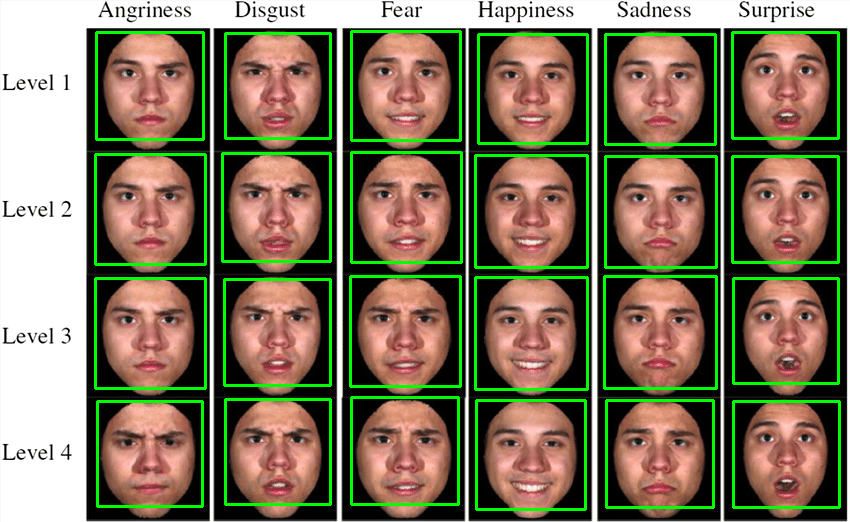

In [0]:
data = {}
file_output = open(image_input+".json","w")

i = 0
for (x, y, w, h) in faces:
    data[str(i)] = {
        "x":str(x),
        "y":str(y),
        "w":str(w),
        "h":str(h)
    }
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    i+=1

json.dump(data,file_output)
file_output.close()
cv2_imshow(image)

In [0]:
!cp "drive/My Drive/fer2013/fer2013.csv" .

In [0]:
import csv
import os
import shutil
import numpy as np

Generate dataset

In [0]:
label_map = ["Angry","Disgust","Fear","Happy","Neutral","Sad","Surprise",]
enable_vec = [1,1,1,1,1,1,1]

In [0]:
dataset_root ="facial_expressions"
folder = ["training","test"]


if os.path.exists(dataset_root):
  shutil.rmtree(dataset_root)

os.mkdir(dataset_root)
for f in folder:
  os.mkdir(dataset_root+"/"+f)
  i = 0
  for label in label_map:
    if enable_vec[i] == 1:
      os.mkdir(dataset_root+"/"+f+"/"+label)
    i+=1

fer2013 = open("fer2013.csv","r")
csv_reader = csv.reader(fer2013,delimiter=",")
id = 0

for row in csv_reader:
  target = "test"
  if row[2]!="training":
    target = "training"
  
  img = np.fromstring(row[1],dtype=int,sep=' ')
  if len(img)!=0 and enable_vec[int(row[0])] ==1:
    img = img.reshape(48,48).astype('float32')
    img = cv2.resize(img, (224,224))
    cv2.imwrite(dataset_root+"/"+target+"/"+label_map[int(row[0])]+"/"+row[0]+"_"+str(id)+".jpg",img)
    id+=1

In [0]:
i = 0
for fol in folder:
  for label in label_map:
    if enable_vec[i] == 1:
      print(fol+": "+label+": "+str(len(os.listdir(dataset_root+"/"+fol+"/"+label))))

training: Angry: 4953
training: Disgust: 547
training: Fear: 5121
training: Happy: 8989
training: Neutral: 6077
training: Sad: 4002
training: Surprise: 6198
test: Angry: 0
test: Disgust: 0
test: Fear: 0
test: Happy: 0
test: Neutral: 0
test: Sad: 0
test: Surprise: 0


In [0]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import *
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
from keras import preprocessing

Using TensorFlow backend.


In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [0]:
!pip install -q -U tensorflow_hub
!pip install -q tf-nightly-gpu

     |████████████████████████████████| 400.2MB 26kB/s 
     |████████████████████████████████| 61kB 16.6MB/s 
     |████████████████████████████████| 501kB 37.4MB/s 
     |████████████████████████████████| 4.1MB 31.0MB/s 


In [0]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [0]:
#feature_extractor_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
#feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3"

In [0]:
IMAGE_SHAPE = (224, 224)
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory("facial_expressions/training", target_size=IMAGE_SHAPE)

Found 35887 images belonging to 7 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 7)


In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 21,817,127
Trainable params: 14,343
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

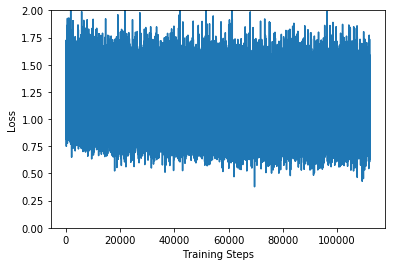

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

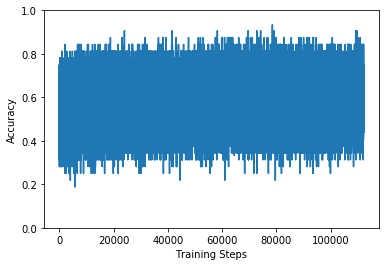

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [0]:
import time
t = time.time()

export_path = "saved_model.tf"
tf.keras.models.save_model(model, export_path)

export_path

'saved_model.tf'

In [0]:
!cp saved_model.tf "drive/My Drive/facial_model.tf"

Load saved model

In [0]:
loaded_model = tf.keras.models.load_model("models/saved_model.tf",custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
inference_x = []
face_list = []
for key in data:
  dat = data[key]
  x = int(dat.get('x'))
  y = int(dat.get('y'))
  w = int(dat.get('w'))
  h = int(dat.get('h'))
  crop_img = image_origin[y:y+h, x:x+w]
  resized_img = cv2.resize(crop_img, dsize=(224, 224))

  cv2_imshow(resized_img)
  face_list.append(resized_img)
  resized_img = np.expand_dims(resized_img, axis=0)
  inference_x.append(resized_img.astype('float32'))
print(inference_x)

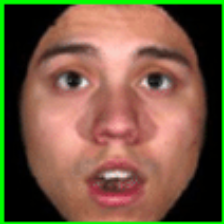

Angry:0.0067
Disgust:0.0908
Fear:0.2157
Happy:0.1058
Neutral:0.1668
Sad:0.0018
Surprise:0.4125


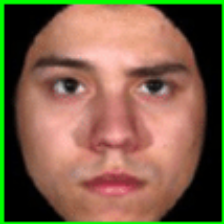

Angry:0.0270
Disgust:0.0166
Fear:0.0347
Happy:0.3754
Neutral:0.2512
Sad:0.0003
Surprise:0.2948


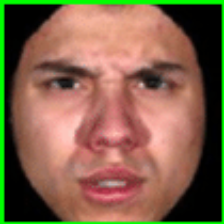

Angry:0.4092
Disgust:0.0081
Fear:0.0507
Happy:0.1075
Neutral:0.2773
Sad:0.0003
Surprise:0.1468


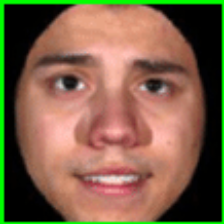

Angry:0.0059
Disgust:0.0180
Fear:0.0360
Happy:0.7223
Neutral:0.1091
Sad:0.0005
Surprise:0.1083


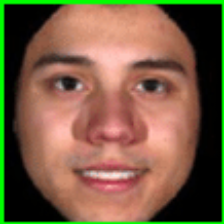

Angry:0.0238
Disgust:0.0012
Fear:0.0424
Happy:0.5679
Neutral:0.1030
Sad:0.0016
Surprise:0.2601


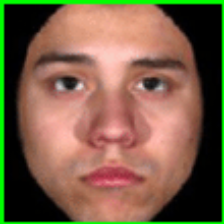

Angry:0.0176
Disgust:0.0056
Fear:0.0482
Happy:0.3246
Neutral:0.0967
Sad:0.0009
Surprise:0.5062


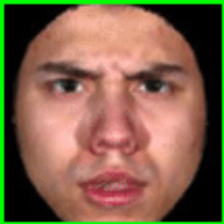

Angry:0.1104
Disgust:0.0062
Fear:0.0999
Happy:0.0373
Neutral:0.3755
Sad:0.0008
Surprise:0.3699


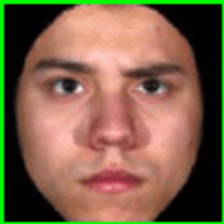

Angry:0.0173
Disgust:0.0161
Fear:0.0739
Happy:0.2967
Neutral:0.4109
Sad:0.0006
Surprise:0.1844


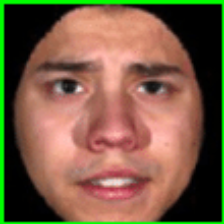

Angry:0.0073
Disgust:0.5839
Fear:0.0529
Happy:0.0942
Neutral:0.1568
Sad:0.0012
Surprise:0.1037


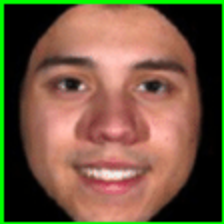

Angry:0.0266
Disgust:0.0027
Fear:0.0213
Happy:0.8861
Neutral:0.0345
Sad:0.0008
Surprise:0.0280


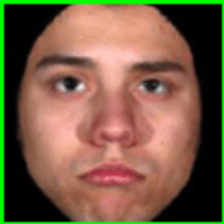

Angry:0.0192
Disgust:0.0170
Fear:0.0433
Happy:0.5790
Neutral:0.0369
Sad:0.0005
Surprise:0.3041


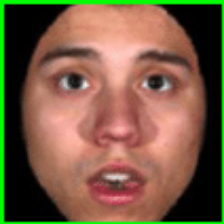

Angry:0.0216
Disgust:0.0050
Fear:0.1715
Happy:0.3130
Neutral:0.2257
Sad:0.0002
Surprise:0.2630


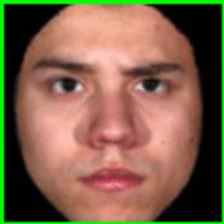

Angry:0.0274
Disgust:0.0067
Fear:0.0623
Happy:0.0786
Neutral:0.4080
Sad:0.0009
Surprise:0.4161


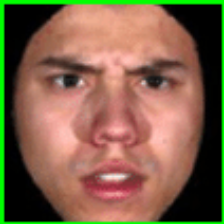

Angry:0.2222
Disgust:0.0006
Fear:0.0588
Happy:0.1980
Neutral:0.3028
Sad:0.0002
Surprise:0.2175


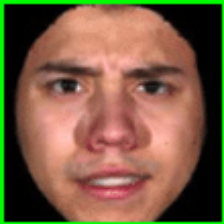

Angry:0.1083
Disgust:0.0489
Fear:0.1729
Happy:0.1344
Neutral:0.4096
Sad:0.0031
Surprise:0.1229


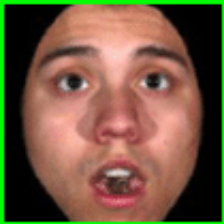

Angry:0.2017
Disgust:0.0287
Fear:0.3425
Happy:0.0557
Neutral:0.1204
Sad:0.0036
Surprise:0.2474


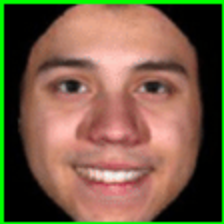

Angry:0.0131
Disgust:0.0003
Fear:0.0149
Happy:0.9286
Neutral:0.0225
Sad:0.0008
Surprise:0.0198


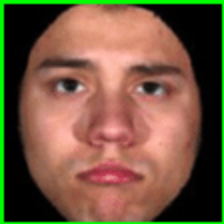

Angry:0.0175
Disgust:0.1159
Fear:0.0516
Happy:0.4615
Neutral:0.0876
Sad:0.0002
Surprise:0.2658


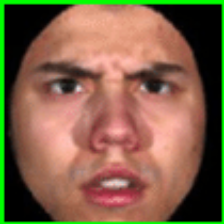

Angry:0.1691
Disgust:0.0127
Fear:0.1684
Happy:0.0276
Neutral:0.2418
Sad:0.0033
Surprise:0.3771


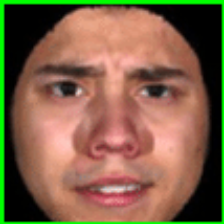

Angry:0.0394
Disgust:0.4276
Fear:0.0813
Happy:0.2140
Neutral:0.1869
Sad:0.0005
Surprise:0.0504


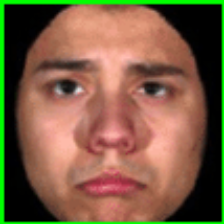

Angry:0.0144
Disgust:0.0272
Fear:0.1536
Happy:0.0348
Neutral:0.2156
Sad:0.0036
Surprise:0.5508


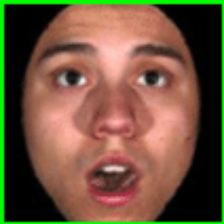

Angry:0.0373
Disgust:0.0139
Fear:0.5035
Happy:0.1770
Neutral:0.0514
Sad:0.0011
Surprise:0.2159


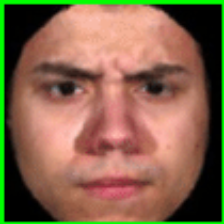

Angry:0.1222
Disgust:0.1547
Fear:0.0309
Happy:0.0879
Neutral:0.4423
Sad:0.0002
Surprise:0.1618


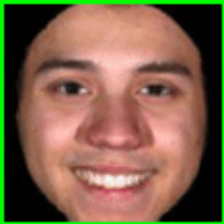

Angry:0.0030
Disgust:0.0036
Fear:0.0128
Happy:0.9628
Neutral:0.0049
Sad:0.0004
Surprise:0.0124


In [0]:
k = 0
for input_x in inference_x:
  cv2_imshow(face_list[k])
  preds = model.predict(input_x/255)
  i = 0
  for pred in preds[0]:
    print("%s:%.4f"%(label_map[i],pred))
    i+=1
  k+=1

Save created model to GDrive

In [0]:
!cp models/saved_model.tf "drive/My Drive/facial_expression_model.tf"